In [ ]:
!pip install -q osmnx

In [ ]:
import json
import random
import time

import dask.bag as db
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm

import graph_search_algorithm_compilation
from networkx.algorithms.components import weakly_connected_components, strongly_connected_components

# import nx_cugraph as nxcg
# from joblib import Parallel, delayed


In [2]:
if 'client' in globals():
    client.close()
client = Client(memory_limit='auto')

### Define Functions

In [3]:
# Generate a random weighted MultiDiGraph for the simulation
# def generate_random_graph(num_nodes, prob=0.1, max_weight=10):
#     G = nx.generators.random_graphs.gnp_random_graph(num_nodes, prob, directed=True)
#     G = nx.MultiDiGraph(G)  # Convert to MultiDiGraph to allow multiple edges between nodes

# Generate a random weighted graph for the simulation
def generate_random_graph(num_nodes, prob=0.1, max_weight=10):
    G = nx.gnp_random_graph(num_nodes, prob, directed=True)
    G = nx.MultiDiGraph(G)

    # Create a static list of edges to avoid modifying G.edges() while iterating
    for u, v in list(G.edges()):
        weight = random.randint(1, max_weight)
        G.add_edge(u, v, length=weight, weight=weight)  # Set the 'length' attribute as the primary weight
        # G[u][v] = {'length': weight, 'weight': weight}

    return G

In [4]:
# Apply flood conditions to the graph
def apply_flood_conditions(G, flood_probability):
    flooded_edges = []
    for u, v in list(G.edges()):
        if random.random() < flood_probability:
            flooded_edges.append((u, v))
            G.remove_edge(u, v)  # Remove the flooded edges from the graph
    return G

Algorithms used to calculate shortest path (bidirectional fastest)

In [5]:
algorithms = {
    "Dijkstra": graph_search_algorithm_compilation.dijkstra_search,
    "Floyd-Warshall": graph_search_algorithm_compilation.floyd_warshall_search,
    "Bellman-Ford": graph_search_algorithm_compilation.bellman_ford_search,
    "Bidirectional": graph_search_algorithm_compilation.bidirectional_search,
    "Dynamic": graph_search_algorithm_compilation.dynamic_shortest_path,
    "A* Search": graph_search_algorithm_compilation.a_star_search,
    # "D* Lite": graph_search_algorithm_compilation.d_star_lite,
    # "MCTS": graph_search_algorithm_compilation.monte_carlo_tree_search,
    # "Yen's K-Shortest Paths": graph_search_algorithm_compilation.yen_k_shortest_paths,
    # "ACO": graph_search_algorithm_compilation.ant_colony_optimization,
}

In [6]:
def create_subgraph(G):
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    SG = G.__class__()
    SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
    if SG.is_multigraph():
        SG.add_edges_from(
            (n, nbr, key, d)
            for n, nbrs in G.adj.items()
            if n in largest_wcc
            for nbr, keydict in nbrs.items()
            if nbr in largest_wcc
            for key, d in keydict.items()
        )
    else:
        SG.add_edges_from(
            (n, nbr, d)
            for n, nbrs in G.adj.items()
            if n in largest_wcc
            for nbr, d in nbrs.items()
            if nbr in largest_wcc
        )
    SG.graph.update(G.graph)
    return SG

In [ ]:
def create_coarse_graph(G, communities):
    supernode_graph = nx.Graph()

    # Add nodes representing communities
    for i in range(len(communities)):
        supernode_graph.add_node(i)

    # Create a mapping of nodes to their respective community indices for quick lookup
    node_to_community = {node: i for i, community in enumerate(communities) for node in community}

    # Add edges between communities based on connections in the original graph
    for u, v, data in G.edges(data=True):
        if 'length' in data:
            # Get the community indices for the nodes u and v
            comm_u = node_to_community.get(u)
            comm_v = node_to_community.get(v)

            # Only proceed if u and v belong to different communities
            if comm_u is not None and comm_v is not None and comm_u != comm_v:
                # Check if the edge already exists and update the weight
                if supernode_graph.has_edge(comm_u, comm_v):
                    # Update the weight to the minimum length if an edge already exists
                    current_weight = supernode_graph[comm_u][comm_v]['weight']
                    supernode_graph[comm_u][comm_v]['weight'] = min(current_weight, data['length'])
                else:
                    # Create the edge with the initial length
                    supernode_graph.add_edge(comm_u, comm_v, weight=data['length'])

    return supernode_graph

In [7]:
def calculate_nearest_boundary_nodes(G, supernode_graph, communities, source, target):
    # Build node-community map in parallel
    community_bag = db.from_sequence(enumerate(communities))
    node_community_map = dict(community_bag.map(lambda x: [(node, x[0]) for node in x[1]]).flatten().compute())

    # Step 1: Find the source and target communities in parallel
    source_community = delayed(lambda: node_community_map.get(source))()
    target_community = delayed(lambda: node_community_map.get(target))()
    source_community, target_community = compute(source_community, target_community)
    
    # Step 2: Calculate the shortest path in the supernode graph
    superpath = np.array(nx.shortest_path(supernode_graph, source=source_community, target=target_community))

    # Step 3: Find all boundary nodes between communities
    intermediate_community_pairs = np.stack((superpath[:-1], superpath[1:]), axis=1)
    
    
    def get_boundary_nodes_np(pair):
        """Returns boundary nodes as a 2D NumPy array for two communities."""
        comm1, comm2 = pair[0], pair[1]
        comm1_nodes = np.array(communities[comm1], ndmin=1)
        comm2_nodes = np.array(communities[comm2], ndmin=1)
    
        # Generate all pairs between comm1 and comm2 without using product
        boundary_pairs = []
        for u in comm1_nodes[0]:
            for v in comm2_nodes[0]:
                if G.has_edge(u, v):
                    boundary_pairs.append((u, v))
    
        return np.array(boundary_pairs)

    boundary_nodes_list = [get_boundary_nodes_np(pair) for pair in intermediate_community_pairs]
    boundary_nodes = np.concatenate(boundary_nodes_list) if boundary_nodes_list else np.empty((0, 2), dtype=int)
    if boundary_nodes.size == 0:
        raise Exception("No path between these communities in the original graph")

        # Step 4: Compute edge lengths using NumPy operations
    def calculate_edge_lengths(boundary_nodes):
        """Returns the minimum-length boundary node pair."""
        edge_lengths = np.array([
            min(data.get('length', float('inf')) for data in G.get_edge_data(u, v, default={}).values())
            for u, v in boundary_nodes
        ])
        return boundary_nodes[np.argmin(edge_lengths)]

    # Find the boundary node with the minimum edge length
    boundary_node_source, boundary_node_target = calculate_edge_lengths(boundary_nodes)
    return boundary_node_source, boundary_node_target


def hierarchical_shortest_path_numpy(G, source, target, algorithm, boundary_nodes):
    # Build node-community map in parallel

    # # Step 5: Calculate all paths in bulk using the algorithm
    # def calculate_path_segments(current_node, boundary_nodes):
    #     """Uses algorithm to get paths to each boundary node."""
    #     return np.array([algorithm(G, source=current_node, target=boundary[0])[1:] for boundary in boundary_nodes], dtype=object)

    # Collect the full path using NumPy
    # initial_paths = calculate_path_segments(source, boundary_nodes)
    # full_path = np.concatenate(([source], *initial_paths.flatten()))

    # Final path segment from the last boundary node to the target
    full_path = [source]
    initial_path = algorithm(G, source=source, target=boundary_nodes[0], weight='length')[1:]
    final_path = algorithm(G, source=boundary_nodes[1], target=target, weight='length')[1:]
    full_path.extend(initial_path + final_path)

    return full_path


# def hierarchical_shortest_path(G, supernode_graph, communities, source, target, algorithm):
#     # Build node-community map in parallel
#     community_bag = db.from_sequence(enumerate(communities))
#     node_community_map = dict(community_bag.map(lambda x: [(node, x[0]) for node in x[1]]).flatten().compute())
# 
#     # Step 1: Find the communities in parallel
#     source_community = delayed(lambda: node_community_map.get(source))()
#     target_community = delayed(lambda: node_community_map.get(target))()
#     source_community, target_community = compute(source_community, target_community)
# 
#     # Step 2: Find the shortest path in the supernode graph
#     superpath = nx.shortest_path(supernode_graph, source=source_community, target=target_community)
# 
#     # Step 3: Refinement within communities
#     full_path = [source]
#     current_node = source
# 
#     for i in range(len(superpath) - 1):
#         community1, community2 = superpath[i], superpath[i + 1]
# 
#         # Find connecting nodes in parallel using itertools.product for Cartesian product
#         boundary_nodes_combinations = product(communities[community1], communities[community2])
#         boundary_nodes_bag = db.from_sequence(boundary_nodes_combinations)
# 
#         # Filter for actual edges between communities
#         boundary_nodes = boundary_nodes_bag.filter(lambda x: G.has_edge(x[0], x[1])).compute()
# 
#         if not boundary_nodes:
#             raise Exception("No path between these communities in the original graph")
# 
#         # Find boundary node with minimum length using parallel mapping
#         def edge_length(pair):
#             edge_data = G.get_edge_data(pair[0], pair[1], default={})
#             print(edge_data)
#             return min(data.get('length', float('inf')) for data in edge_data.values()) if edge_data else float('inf')
# 
#         boundary_node = min(boundary_nodes, key=edge_length)
# 
#         # Find shortest path from current_node to boundary_node in parallel
#         path_within_community = algorithm(G, source=current_node, target=boundary_node[0])
#         full_path.extend(path_within_community[1:])
# 
#         # Set up next node for iteration
#         current_node = boundary_node[1]
# 
#     # Final path segment
#     final_path = algorithm(G, source=current_node, target=target, weight='length')
#     full_path.extend(final_path[1:])
# 
#     return full_path

In [8]:
# Parallel execution using Dask
@delayed
def evaluate_algorithm(G, source, target, algorithm, boundary_nodes):
    start_time = time.perf_counter()
    try:
        # Call the algorithm with (G, source, target, weight)
        path = hierarchical_shortest_path_numpy(G, source, target, algorithm, boundary_nodes)
        duration = time.perf_counter() - start_time
        if path is None:
            return float('inf'), []  # Infinite cost for no path found
        return duration, path  # Return computation time and the path
    except Exception as e:
        return float('inf'), []  # Infinite cost for errors


# Run algorithms in parallel using Dask
def run_in_parallel(algorithms, graph, source, target, boundary_nodes):

    delayed_results = [
        evaluate_algorithm(graph, source, target, algo_func, boundary_nodes) 
        for algo_func in algorithms.values()
    ]

    results = compute(*delayed_results)
    return results


# Step 1: Detect Louvain communities and create the supernode graph
def detect_communities_and_supernode_graph(G, weight='weight'):
    communities = nx.community.louvain_communities(G, weight)
    supernode_graph = create_coarse_graph(G, communities)
    return communities, supernode_graph
    

# Monte Carlo Simulation: Run all algorithms in parallel on the same graph
def monte_carlo_simulation(graph, num_iterations):
    graph = graph.copy()
    algorithm_performance = {name: [] for name in algorithms.keys()}  # Track performance for each algorithm

    source = random.choice(list(graph.nodes()))
    target = random.choice(list(graph.nodes()))

    # Ensure source and target are not the same
    while source == target:
        target = random.choice(list(graph.nodes()))

    communities, supernode_graph = detect_communities_and_supernode_graph(graph)
    boundary_nodes = calculate_nearest_boundary_nodes(graph, supernode_graph, communities, source, target)

    # Step 4: Evaluate all algorithms in parallel over the same graph, flooded conditions, and source/target
    for _ in tqdm(range(num_iterations)):
        results = run_in_parallel(algorithms, graph, source, target, boundary_nodes)

        # Store results in performance dictionary
        for algo_name, result in zip(algorithms.keys(), results):
            algorithm_performance[algo_name].append(result)

    return algorithm_performance

In [9]:
# Choose the best algorithm based on the performance and return the best result
def choose_best_algorithm(algorithm_performance):
    # Calculate average performance for each algorithm
    avg_performance = {
        algo: sum(duration for duration, _ in times) / len(times)
        for algo, times in algorithm_performance.items()
    }

    # Select the algorithm with the lowest average time
    best_algorithm = min(avg_performance, key=avg_performance.get)

    # Output the performance of all algorithms
    print(f"Best algorithm: {best_algorithm}")
    for algo, avg_time in avg_performance.items():
        print(f"{algo}: {avg_time:.4f} seconds (average)")

    # Return the best algorithm and its last run output (path)
    best_run = algorithm_performance[best_algorithm][-1]  # Get the last run result
    return best_algorithm, best_run[1]  # Return the algorithm name and its path

In [10]:
# Monte Carlo Simulation Parameters
iterations = 100  # Number of Monte Carlo iterations
graph_size = 100    # Number of nodes in the graph
flooded_road_probability = 0.1  # Probability that a road gets flooded

G = generate_random_graph(graph_size)

# apply flood conditions once
graph = apply_flood_conditions(G, flooded_road_probability)
# graph = nxcg.from_networkx(graph)

In [11]:
# Run the simulation
algorithm_performance = monte_carlo_simulation(graph, iterations)

100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


Best algorithm: Bidirectional
Dijkstra: 0.0001 seconds (average)
Floyd-Warshall: inf seconds (average)
Bellman-Ford: 0.1188 seconds (average)
Bidirectional: 0.0000 seconds (average)
Dynamic: 0.0001 seconds (average)
A* Search: 0.0001 seconds (average)
Best path found by Bidirectional: [7, 1]


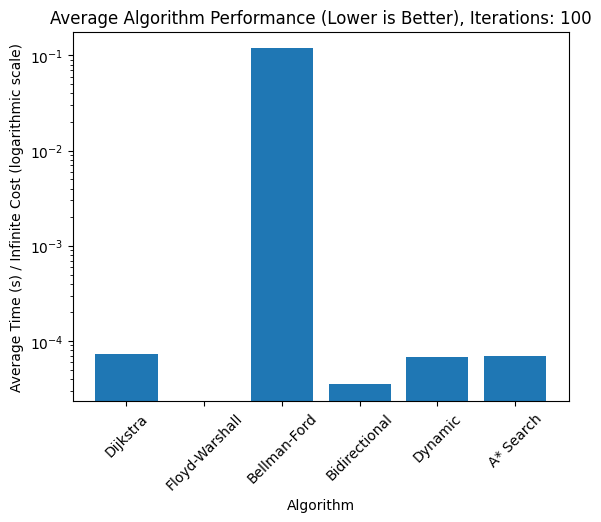

In [12]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}

# Display the average performance results
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Import Graph of Metro Manila


In [13]:
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [121.0017, 14.5361]
  },
  "properties": {}
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI = AOI.buffer(0.01)
AOI

0    POLYGON ((121.01170 14.53610, 121.01165 14.535...
dtype: geometry

In [14]:
WEST_BBOX, SOUTH_BBOX, EAST_BBOX, NORTH_BBOX = AOI.total_bounds

In [32]:
# bounding box for Metro Manila
# NORTH_BBOX = 14.7430
# SOUTH_BBOX = 14.4560
# WEST_BBOX = 120.9306
# EAST_BBOX = 121.1353

In [17]:
METRO_MANILA_BOUNDING_BOX = (NORTH_BBOX, SOUTH_BBOX, EAST_BBOX, WEST_BBOX)

In [75]:
metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)

C:\Users\Jed Padro\AppData\Local\Temp\ipykernel_19816\4238480312.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)


In [19]:
def add_weight_from_length(G):
    # Iterate through each edge and set 'weight' to the value of 'length'
    for u, v, data in G.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']  # Copy 'length' to 'weight'
        else:
            data['weight'] = 0  # Set a default weight if 'length' is missing

add_weight_from_length(metro_manila_graph)

In [54]:
ox.save_graphml(metro_manila_graph, '../graphs/graphml/metro_manila_graph_small.graphml')

In [77]:
fp = '../graphs/graphml/metro_manila_graph_small.graphml'
metro_manila_graph = ox.load_graphml(fp)

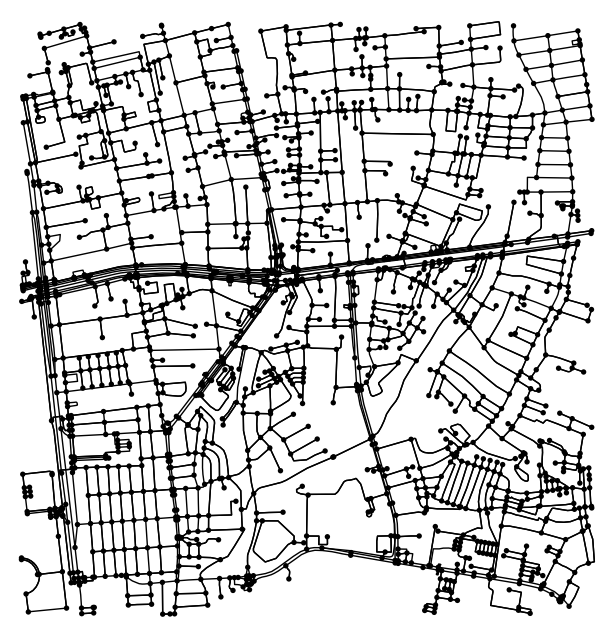

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [90]:
ox.plot_graph(metro_manila_graph, bgcolor='#ffffff', node_color='#000000', edge_color='#000000')

In [16]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(metro_manila_graph)

In [17]:
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
12067302,14.541506,120.994972,3,NaN,NaN,POINT (120.99497 14.54151)
12067308,14.537867,120.995733,3,NaN,NaN,POINT (120.99573 14.53787)
12067317,14.540634,120.992152,3,NaN,NaN,POINT (120.99215 14.54063)
12067355,14.538879,121.010825,3,NaN,NaN,POINT (121.01083 14.53888)
12072883,14.555428,121.004165,4,NaN,NaN,POINT (121.00417 14.55543)


In [18]:
gdf_edges.head()

osmid                   name  \
u        v          key                                                  
12067302 1686647100 0                   2667105     E. Manaloto Street   
         2950125788 0                 224039651  F. B. Harrison Street   
         6510185271 0                 224039651  F. B. Harrison Street   
12067308 8562405196 0                 224039655  F. B. Harrison Street   
         1723298722 0    [644875507, 840378998]                   EDSA   

                             highway  oneway reversed   length   weight  \
u        v          key                                                   
12067302 1686647100 0    residential   False     True  129.271  129.271   
         2950125788 0      secondary   False    False   34.788   34.788   
         6510185271 0      secondary   False     True   64.711   64.711   
12067308 8562405196 0      secondary   False     True    6.003    6.003   
         1723298722 0          trunk    True    False  175.734  175.734   

                          lanes maxspeed width  \
u        v          key                          
12067302 1686647100 0       NaN      NaN   NaN   
         2950125788 0         2       40     8   
         6510185271 0         2       40     8   
12067308 8562405196 0         2       40     8   
         1723298722 0    [4, 5]       60   NaN   

                                                                  geometry  \
u        v          key                                                      
12067302 1686647100 0    LINESTRING (120.99497 14.54151, 120.99380 14.5...   
         2950125788 0    LINESTRING (120.99497 14.54151, 120.99504 14.5...   
         6510185271 0    LINESTRING (120.99497 14.54151, 120.99486 14.5...   
12067308 8562405196 0    LINESTRING (120.99573 14.53787, 120.99572 14.5...   
         1723298722 0    LINESTRING (120.99573 14.53787, 120.99516 14.5...   

                         ref access service junction tunnel bridge  
u        v          key                                             
12067302 1686647100 0    NaN    NaN     NaN      NaN    NaN    NaN  
         2950125788 0    NaN    NaN     NaN      NaN    NaN    NaN  
         6510185271 0    NaN    NaN     NaN      NaN    NaN    NaN  
12067308 8562405196 0    NaN    NaN     NaN      NaN    NaN    NaN  
         1723298722 0      1    NaN     NaN      NaN    NaN    NaN

In [19]:
gdf_edges.columns

Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'weight',
       'lanes', 'maxspeed', 'width', 'geometry', 'ref', 'access', 'service',
       'junction', 'tunnel', 'bridge'],
      dtype='object')

In [20]:
gdf_nodes.columns

Index(['y', 'x', 'street_count', 'highway', 'ref', 'geometry'], dtype='object')

In [70]:
path = graph_search_algorithm_compilation.bidirectional_search(metro_manila_graph, 12067302, 12067308)
path

[12067302,
 2950125788,
 5354424837,
 24785165,
 5651175582,
 25388521,
 8317435077,
 25389123,
 25388522,
 978165773,
 445413656,
 8562405196,
 12067308]

In [71]:
metro_manila_graph.edges(data=True)

OutMultiEdgeDataView([(12067302, 1686647100, {'osmid': 2667105, 'name': 'E. Manaloto Street', 'highway': 'residential', 'oneway': False, 'reversed': True, 'length': 129.271, 'weight': 129.271}), (12067302, 2950125788, {'osmid': 224039651, 'lanes': '2', 'name': 'F. B. Harrison Street', 'highway': 'secondary', 'maxspeed': '40', 'width': '8', 'oneway': False, 'reversed': False, 'length': 34.788000000000004, 'geometry': <LINESTRING (120.995 14.542, 120.995 14.541, 120.995 14.541)>, 'weight': 34.788000000000004}), (12067302, 6510185271, {'osmid': 224039651, 'lanes': '2', 'name': 'F. B. Harrison Street', 'highway': 'secondary', 'maxspeed': '40', 'width': '8', 'oneway': False, 'reversed': True, 'length': 64.711, 'geometry': <LINESTRING (120.995 14.542, 120.995 14.542, 120.995 14.542)>, 'weight': 64.711}), (12067308, 8562405196, {'osmid': 224039655, 'lanes': '2', 'name': 'F. B. Harrison Street', 'highway': 'secondary', 'maxspeed': '40', 'width': '8', 'oneway': False, 'reversed': True, 'length'

#### Sample Graph for Visualization

Nodes in the condensed graph: [(0, {'members': {4}}), (1, {'members': {1, 2, 3}})]
Edges in the condensed graph: [(1, 0, {})]
Nodes in the condensed graph: [(1, {}), (2, {}), (3, {}), (4, {})]
Edges in the condensed graph: [(1, 2, {}), (2, 3, {}), (3, 1, {}), (3, 4, {})]


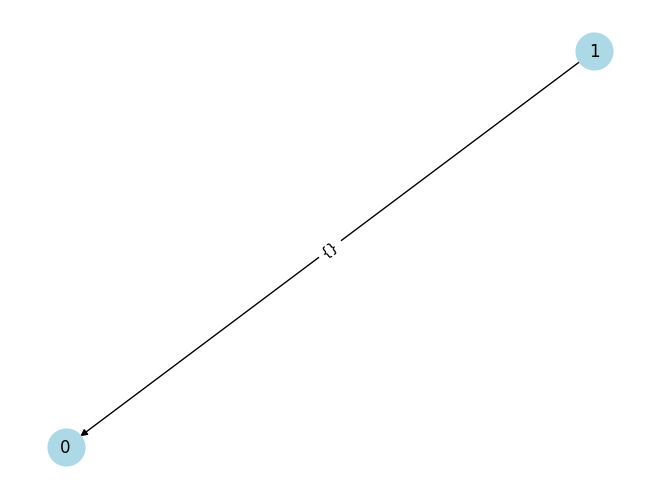

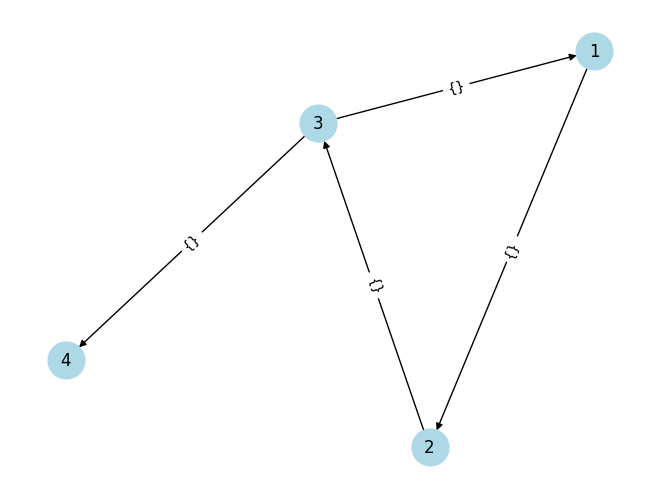

AttributeError: 'list' object has no attribute 'is_directed'

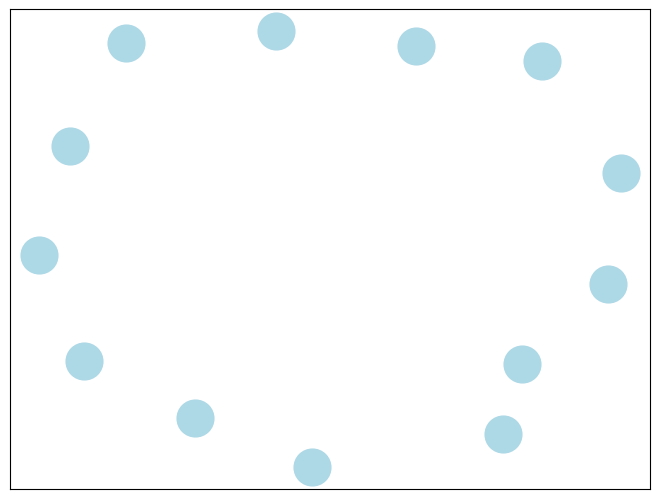

In [56]:
def sample_graph_condensation():
    # Create a MultiDiGraph
    G = nx.MultiDiGraph()
    G.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4)])
    
    # Apply condensation
    C = nx.condensation(G)
    D = G
    
    # Print nodes and edges of the condensed graph
    print("Nodes in the condensed graph:", C.nodes(data=True))
    print("Edges in the condensed graph:", C.edges(data=True))
    
    print("Nodes in the condensed graph:", D.nodes(data=True))
    print("Edges in the condensed graph:", D.edges(data=True))
    
    # print("Nodes in the condensed graph:", path.nodes(data=True))
    # print("Edges in the condensed graph:", path.edges(data=True))
    
    # Visualize the condensed graph
    pos = nx.spring_layout(C)
    nx.draw(C, pos, with_labels=True, node_size=700, node_color="lightblue")
    nx.draw_networkx_edge_labels(C, pos, edge_labels={(u, v): d for u, v, d in C.edges(data=True)})
    plt.show()
    
    pos = nx.spring_layout(D)
    nx.draw(D, pos, with_labels=True, node_size=700, node_color="lightblue")
    nx.draw_networkx_edge_labels(D, pos, edge_labels={(u, v): d for u, v, d in D.edges(data=True)})
    plt.show()
    
    pos = nx.spring_layout(path)
    nx.draw(path, pos, with_labels=True, node_size=700, node_color="lightblue")
    nx.draw_networkx_edge_labels(path, pos, edge_labels={(u, v): d for u, v, d in path.edges(data=True)})
    plt.show()
    
sample_graph_condensation()

#### Sample Graph conclusion

In [80]:
# Load the graph from the .graphml file
graph_path = '../graphs/graphml/metro_manila_graph_small.graphml'
GRAPH = nx.read_graphml(graph_path)

In [85]:
def condense_graph(GRAPH):
    """
    Condense the graph by combining nodes with degree 2 into single edges.
    
    G: Input graph (NetworkX graph)
    
    Returns:
        Condensed graph (NetworkX graph)
    """
    # Copy graph to avoid modifying the original
    H = GRAPH.copy()

    # Find and condense paths
    for node in list(H.nodes()):
        # Only consider nodes with degree 2
        if H.degree(node) == 2:
            neighbors = list(H.neighbors(node))
            if len(neighbors) == 2:
                u, v = neighbors
                # Combine the edges and create a new direct edge from u to v
                # with combined weights or other attributes as necessary
                if not H.has_edge(u, v):
                    weight = H[u][node].get('weight', 1) + H[node][v].get('weight', 1)
                    H.add_edge(u, v, weight=weight)
                # Remove the intermediate node
                H.remove_node(node)

    return H

In [86]:
# Find weakly connected components (WCCs) of the graph
wcc = list(nx.weakly_connected_components(G))

# Generate the condensation of the graph using WCCs
condensed_graph = nx.condensation(GRAPH, scc=wcc)

# Display basic information about the condensed graph
# print("Condensed graph information:")
# print(nx.info(condensed_graph))
print(GRAPH)
print(condensed_graph)

MultiDiGraph with 6674 nodes and 8352 edges
DiGraph with 799 nodes and 0 edges


In [99]:
graph = metro_manila_graph.copy() 
C = graph
graph = nx.condensation(graph, scc=nx.weakly_connected_components(graph))
print(C)    # Normal NOT Condensed Graph of Metro Manila
print(graph)    # Condensed Graph of Metro Manila
source = 12067302
target = 12067308
communities, supernode_graph = detect_communities_and_supernode_graph(graph)

MultiDiGraph with 6674 nodes and 8352 edges
DiGraph with 799 nodes and 0 edges


In [61]:
# # Create a new MultiDiGraph
# D = nx.MultiDiGraph()
# 
# # Add nodes from the condensed graph
# D.add_nodes_from(C.nodes(data=True))
# 
# # Add edges from the condensed graph
# for u, v, data in C.edges(data=True):
#     D.add_edge(u, v, **data)

In [100]:
# Display the edges and nodes in each graph
print("Nodes in graph:", C.nodes(data=True))
print("Edges in graph:", C.edges(data=True))
print("\n")
print("Nodes in the condensed graph:", graph.nodes(data=True))
print("Edges in the condensed graph:", graph.edges(data=True))

Nodes in graph: [(12067302, {'y': 14.5415061, 'x': 120.9949722, 'street_count': 3}), (12067308, {'y': 14.5378672, 'x': 120.9957327, 'street_count': 3}), (12067317, {'y': 14.5406344, 'x': 120.9921523, 'street_count': 3}), (12067355, {'y': 14.5388794, 'x': 121.0108253, 'street_count': 3}), (12072883, {'y': 14.5554282, 'x': 121.0041654, 'street_count': 4}), (12077431, {'y': 14.5175798, 'x': 120.9931705, 'highway': 'traffic_signals', 'street_count': 4}), (12077464, {'y': 14.5167052, 'x': 121.0011183, 'highway': 'traffic_signals', 'street_count': 3}), (21590461, {'y': 14.5523578, 'x': 120.9893282, 'highway': 'traffic_signals', 'street_count': 4}), (21590462, {'y': 14.5521371, 'x': 120.9893987, 'highway': 'traffic_signals', 'street_count': 4}), (21590463, {'y': 14.5522555, 'x': 120.9898025, 'highway': 'traffic_signals', 'street_count': 4}), (21590464, {'y': 14.5536845, 'x': 120.9947886, 'street_count': 3}), (21590466, {'y': 14.5521352, 'x': 120.9884965, 'street_count': 4}), (21590467, {'y': 

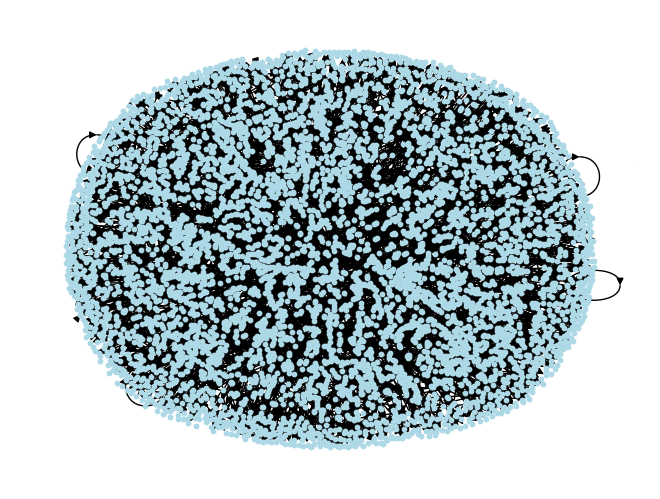

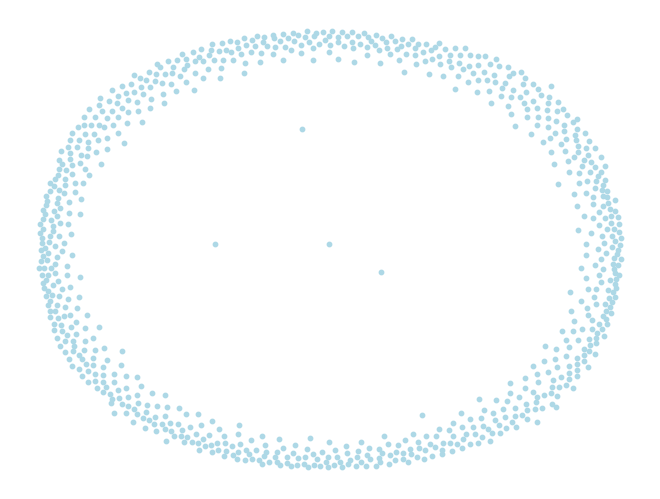

In [101]:
pos = nx.spring_layout(C)
nx.draw(C, pos, with_labels=False, node_size=10, node_color="lightblue")
# nx.draw_networkx_edges(C, pos, edgelist=communities)
# nx.draw_networkx_edge_labels(C, pos, edge_labels=None, font_size=1)
plt.show()

pos = nx.spring_layout(D)
nx.draw(D, pos, with_labels=False, node_size=10, node_color="lightblue")
# nx.draw_networkx_edges(D, pos, edgelist=communities)
# nx.draw_networkx_edge_labels(C, pos, edge_labels=None, font_size=1)
plt.show()

In [91]:
boundary_nodes = calculate_nearest_boundary_nodes(graph, supernode_graph, communities, source, target)
path = hierarchical_shortest_path_numpy(graph, source, target, graph_search_algorithm_compilation.bidirectional_search, boundary_nodes)
path

NetworkXNoPath: No path between 337 and 604.

#### Monte Carlo with Graph of Metro Manila

In [323]:
iterations = 1
flooded_road_probability = 0.1
metro_manila_graph_flooded = apply_flood_conditions(metro_manila_graph.copy(), flooded_road_probability)
metro_manila_graph_flooded = nx.condensation(metro_manila_graph, scc=nx.weakly_connected_components(metro_manila_graph_flooded))
algorithm_performance = monte_carlo_simulation(metro_manila_graph_flooded, iterations)

Exception: No path between these communities in the original graph

Best algorithm: Dijkstra
Dijkstra: inf seconds (average)
Floyd-Warshall: inf seconds (average)
Bellman-Ford: inf seconds (average)
Bidirectional: inf seconds (average)
Dynamic: inf seconds (average)
A* Search: inf seconds (average)
Yen's K-Shortest Paths: inf seconds (average)
Best path found by Dijkstra: []


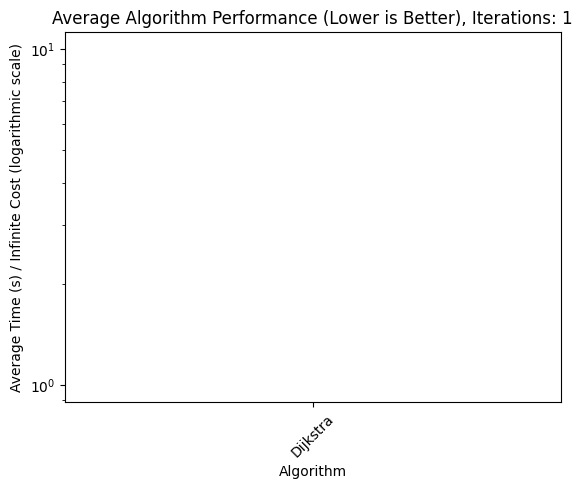

In [98]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Conclusion